In [1]:
import berrylib.util as util
util.setup_nb()

In [2]:
from berrylib.constants import Y_I2, N_I2
import berrylib.fast_inla as fast_inla
import berrylib.mcmc as mcmc
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp

y=Y_I2
n=N_I2

fi = fast_inla.FastINLA(sigma2_n=15)

/Users/tbent/.mambaforge/envs/imprint2/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/tbent/.mambaforge/envs/imprint2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [96]:
mcmc_results = []
for sig_idx in range(fi.sigma2_n):
    mcmc_results.append(mcmc.mcmc_berry(
        np.stack((y[-1:], n[-1:]), axis=-1),
        fi.logit_p1,
        fi.thresh_theta,
        dtype=np.float64,
        n_samples=200000,
        sigma2_val=fi.sigma2_rule.pts[sig_idx]
    ))

In [97]:
mcmc_arm_marg = mcmc.mcmc_berry(
    np.stack((y[-1:], n[-1:]), axis=-1),
    fi.logit_p1,
    fi.thresh_theta,
    dtype=np.float64,
    n_samples=200000,
)

In [3]:
import inlaw
from inlaw.berry_model import berry_model

fl = inlaw.FullLaplace(berry_model(4), "sig2", np.zeros((4,2)))

In [4]:
data = np.stack((y[-1:], n[-1:]), axis=-1)
post, x_max, hess, iters = fl(dict(sig2=fi.sigma2_rule.pts), data)

(4,)
{'sig2': None, 'theta': Traced<ShapedArray(float64[4], weak_type=True)>with<BatchTrace(level=2/1)> with
  val = Traced<ShapedArray(float64[15,4], weak_type=True)>with<BatchTrace(level=1/1)> with
    val = Traced<ShapedArray(float64[4096,15,4], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
    batch_dim = 0
  batch_dim = 0}
(4,)
{'sig2': None, 'theta': Traced<ShapedArray(float64[4], weak_type=True)>with<BatchTrace(level=3/1)> with
  val = Traced<ShapedArray(float64[15,4], weak_type=True)>with<BatchTrace(level=2/1)> with
    val = Traced<ShapedArray(float64[4096,15,4], weak_type=True)>with<DynamicJaxprTrace(level=1/1)>
    batch_dim = 0
  batch_dim = 0}


In [60]:
d = 4
i = 0
i_vec = jnp.eye(d, dtype=bool)[i]
not_i = ~i_vec

def conditional_mu(mu, cov, x):
    cov12 = cov[i, not_i]
    cov22 = cov[i, i]
    mu1 = mu[not_i]
    mu_cond = mu1 + cov12 / cov22 * (x - mu[i_vec])
    mu_out = jnp.empty(d, dtype=mu.dtype).at[i_vec].set(x).at[not_i].set(mu_cond)
    return mu_out

In [73]:
t_i = util.simpson_rule(101, -15, 2)

In [74]:
p_pinned = dict(sig2=fi.sigma2_rule.pts, theta=None)
inv_hess = np.linalg.inv(hess)
cond_mu_f = jax.vmap(jax.vmap(jax.vmap(conditional_mu)), in_axes=(None, None, 0))
cond_mu = cond_mu_f(x_max, inv_hess, np.tile(t_i.pts[:, None, None], (1, x_max.shape[0], x_max.shape[1])))

In [79]:
cond_mu_ravel = cond_mu.reshape((-1, *cond_mu.shape[2:]))
data_ravel = np.tile(data[None], (cond_mu.shape[0], 1, 1, 1)).reshape((-1, *data.shape))

In [81]:
arm_idx = i
grad_hess_f = inlaw.inla.build_grad_hess(fl.log_joint_single, fl.spec)
grad, hess = grad_hess_f(cond_mu_ravel, p_pinned, data_ravel)
# Could pin an extra theta instead of deleting.
cond_hess_inv = jnp.delete(jnp.delete(jnp.linalg.inv(-hess), arm_idx, axis=2), arm_idx, axis=3)

In [110]:
lj = fl.log_joint(cond_mu_ravel, p_pinned, data_ravel)
log_cond_arm_ravel = lj + 0.5 * np.log(np.linalg.det(cond_hess_inv))
log_cond_arm = log_cond_arm_ravel.reshape((-1, *x_max.shape[:-1]))
log_cond_arm -= jnp.max(log_cond_arm)
cond_arm = np.exp(log_cond_arm)
cond_arm /= np.sum(cond_arm * t_i.wts[:, None, None], axis=0)[None]

In [111]:
def conditional_mu(mu, cov, i, x):
    """Return the conditional mean of a multivariate normal given a particular arm value.
    
    https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions
    """
    cov12 = np.delete(cov[i], i)
    cov22 = cov[i, i]
    mu1 = np.delete(mu, i)
    mu2 = mu[i]
    mu_cond = mu1 + cov12 / cov22 * (x - mu2)
    return mu_cond

def cond_laplace(t_i, sigma2_n):
    fi = fast_inla.FastINLA(sigma2_n=sigma2_n)
    data = np.stack((y, n), axis=-1)
    sigma2_post, _, theta_max, theta_sigma, hess_inv = fi.numpy_inference(data)
    arm_idx = 0
    theta_max_cond = np.empty((fi.sigma2_n, t_i.pts.shape[0], 4))
    theta_sigma_cond = np.empty((fi.sigma2_n, t_i.pts.shape[0], 4))
    p_t0_g_sig2_y = np.empty((fi.sigma2_n, t_i.pts.shape[0]))
    for sig_idx in range(fi.sigma2_n):
        for i, t0_val in enumerate(t_i.pts):
            cond_mu = conditional_mu(theta_max[-1, sig_idx], -hess_inv[-1, sig_idx], arm_idx, t0_val)

            theta_max_cond[sig_idx, i, 0] = t0_val
            theta_max_cond[sig_idx, i, 1:] = cond_mu

            exp_theta_adj = np.exp(theta_max_cond[sig_idx, i] + fi.logit_p1)
            C = 1.0 / (exp_theta_adj + 1)
            hess = fi.neg_precQ[sig_idx].copy()
            hess[np.arange(4), np.arange(4)] -= (n[-1] * exp_theta_adj * (C**2))

            cond_hess_inv = np.linalg.inv(hess)
            theta_sigma_cond[sig_idx, i] = np.sqrt(np.diagonal(-cond_hess_inv))

            logjoint = fi.model.log_joint(fi, data[-1:], theta_max_cond[None, sig_idx, i])[0,sig_idx]
            p_t0_g_sig2_y[sig_idx, i] = logjoint + 0.5 * np.log(np.linalg.det(-cond_hess_inv[1:, 1:]))
    laplace = np.exp(p_t0_g_sig2_y)
    laplace /= np.sum(laplace * t_i.wts[None,:], axis=1)[:, None]
    laplace_integral = np.sum(laplace * (sigma2_post[-1] * fi.sigma2_rule.wts)[:, None], axis=0)
    return theta_max, theta_sigma, laplace, laplace_integral, hess_inv

In [112]:
t_i = util.simpson_rule(101, -15, 2)
theta_max, theta_sigma, laplace, laplace_integral, hess_inv = cond_laplace(t_i, fi.sigma2_n)

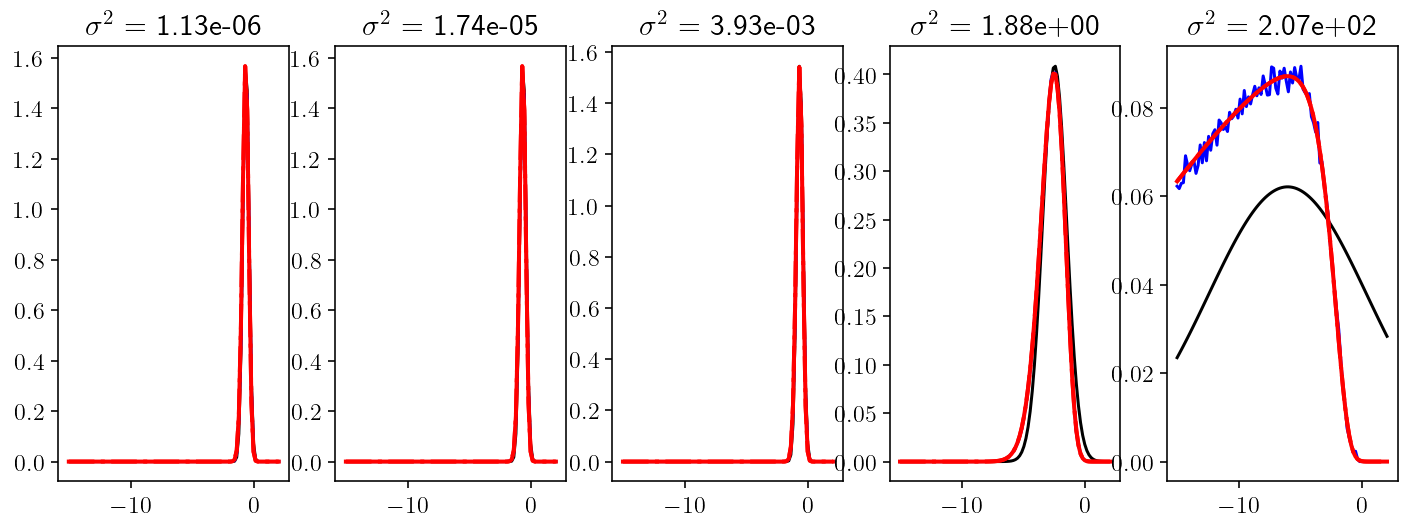

In [103]:
arm_idx = 0
plt.figure(figsize=(12, 4))
for i, sig_idx in enumerate(range(fi.sigma2_n)[::3]):
    mcmc_arm = mcmc_results[sig_idx]["x"][0]["theta"][0, :, arm_idx]
    mcmc_p_ti_g_y = mcmc.calc_pdf(mcmc_arm, t_i.pts, t_i.wts)
    gaussian = scipy.stats.norm.pdf(t_i.pts, theta_max[-1, sig_idx, 0], theta_sigma[-1, sig_idx, 0])

    plt.subplot(1,5,1 + i)
    plt.title(f'$\sigma^2$ = {fi.sigma2_rule.pts[sig_idx]:5.2e}')
    plt.plot(t_i.pts, gaussian, 'k-')
    plt.plot(t_i.pts, mcmc_p_ti_g_y, 'b-')
    plt.plot(t_i.pts, laplace[sig_idx], 'r-', linewidth=2.0)
    plt.plot(t_i.pts, cond_arm[:, 0, sig_idx], 'r-.', linewidth=2.0)
plt.show()

## Jensen-Shannon divergence

[Jensen-Shannon divergence](https://en.wikipedia.org/wiki/Jensen–Shannon_divergence)

https://stats.stackexchange.com/questions/6907/an-adaptation-of-the-kullback-leibler-distance/6937#6937


The symmetric KL divergence doesn't behave well when there are zeros in either distribution. The JS divergence solves this issue by comparing to the midpoint distribution.

More generally, the issue we are faced with is computing a norm of distributions. so something like the L2 norm of the difference of the functions would be fine. But the more probabalistic/informational divergence metrics are probably better.

One way we can avoid this entirely is to move to evaluating error in terms of the final output, the exceedance. In many cases, all we are going to care about is the exceedance prob for some threshold. This is a scalar (or vector with multiple arms) and would make error tolerances more concrete and understandable. 

In [87]:
import scipy.special
def js_div(x, y, wts):
    R = 0.5 * (x + y)
    a = np.sum(wts * scipy.special.rel_entr(x, R))
    b = np.sum(wts * scipy.special.rel_entr(y, R))
    return 0.5 * (a + b)

In [106]:
import pandas as pd
df = pd.DataFrame(dict(sig2 = fi.sigma2_rule.pts))
df['JS_G_M'] = 0
df['JS_L_M'] = 0
for i, sig_idx in enumerate(range(fi.sigma2_n)):
    mcmc_arm = mcmc_results[sig_idx]["x"][0]["theta"][0, :, arm_idx]
    mcmc_p_ti_g_y = mcmc.calc_pdf(mcmc_arm, t_i.pts, t_i.wts)
    gaussian = scipy.stats.norm.pdf(t_i.pts, theta_max[-1, sig_idx, 0], theta_sigma[-1, sig_idx, 0])
    df.at[i, 'JS_G_M'] = js_div(mcmc_p_ti_g_y, gaussian, t_i.wts)
    df.at[i, 'JS_L_M'] = js_div(mcmc_p_ti_g_y, laplace[sig_idx], t_i.wts)
df

,sig2,JS_G_M,JS_L_M
0,0.000001,0.001329,0.001022
1,0.000002,0.000861,0.001355
2,0.000005,0.001104,0.001107
3,0.000017,0.001770,0.000754
4,0.000085,0.001628,0.000636
5,0.000532,0.001511,0.000792
6,0.003932,0.001354,0.000626
7,0.031623,0.001123,0.000299
8,0.254316,0.002730,0.000050
9,1.877937,0.015512,0.000024


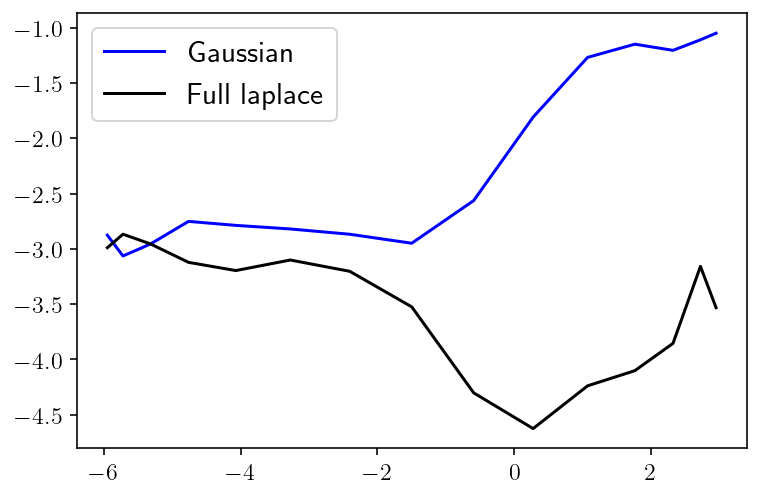

In [111]:
plt.plot(np.log10(df['sig2']), np.log10(df['JS_G_M']), 'b-', label='Gaussian')
plt.plot(np.log10(df['sig2']), np.log10(df['JS_L_M']), 'k-', label='Full laplace')
plt.legend()
plt.show()

In [75]:
mcmc_arm = mcmc_arm_marg["x"][0]["theta"][0, :, arm_idx]
mcmc_p_ti_g_y = mcmc.calc_pdf(mcmc_arm, t_i.pts, t_i.wts)

In [76]:
from scipy.special import logit

In [77]:
t_i = util.simpson_rule(101, -15, 2)
_, _, _, laplace_integral, hess_inv = cond_laplace(t_i, 20)


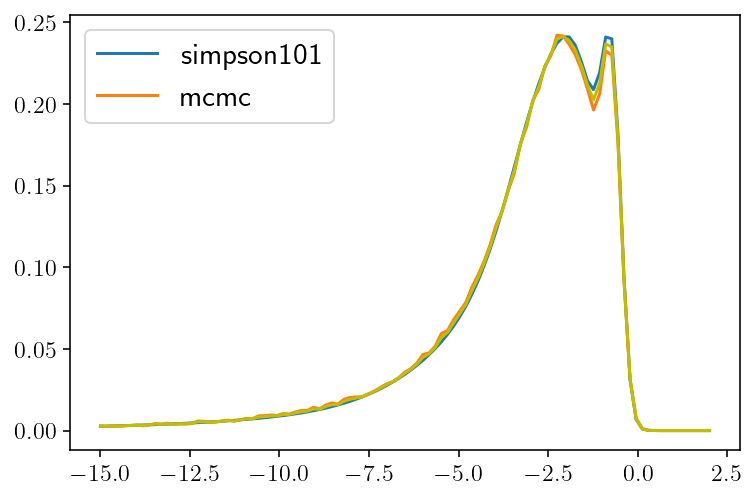

In [79]:

R = 0.5 * (mcmc_p_ti_g_y + laplace_integral)
plt.plot(t_i.pts, laplace_integral, label=f'simpson101')
plt.plot(t_i.pts, mcmc_p_ti_g_y, label='mcmc')
plt.plot(t_i.pts, R, 'y-')

# t_i = util.gauss_rule(20, -15, 2)
# _, _, _, laplace_integral = cond_laplace(t_i, 20)
# plt.plot(t_i.pts, laplace_integral, label=f'gauss20')

# plt.vlines([logit(0.1) - logit(0.3), logit(0.2) - logit(0.3)], 0, 0.25, 'k')

plt.legend()
plt.show()

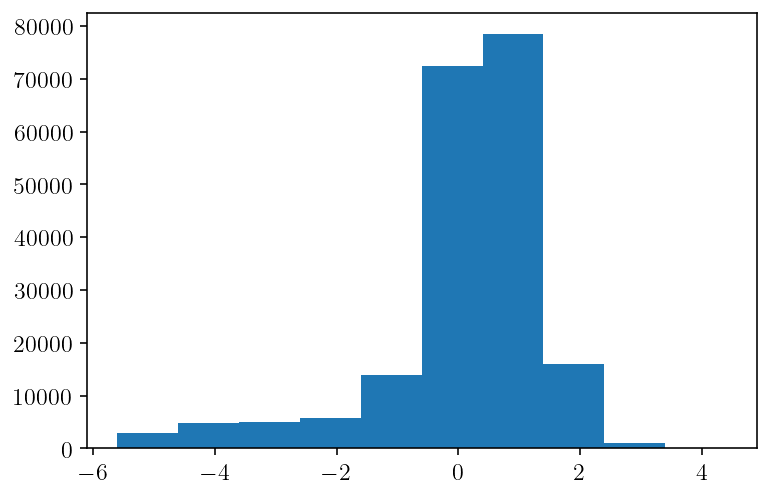

In [42]:
plt.hist(np.log10(mcmc_arm_marg['x'][0]['sigma2'][0]))
plt.show()